In [ ]:
# pip install bertopic
import pandas as pd, numpy as np
from bertopic import BERTopic
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import scipy.sparse
from scipy import sparse
import matplotlib.pyplot as plt

# NLTK
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Langdetect
# pip install pycountry
from langdetect import detect, LangDetectException
import pycountry
import spacy
from sklearn.decomposition import PCA

from collections import Counter
import seaborn as sns

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from umap import UMAP

In [ ]:
df = pd.read_csv("cleaned_grab_playstore_reviews.csv")

In [ ]:
df['Review'].head(10)

0    update poor performance taking minutes search ...
1                                              bad app
2    friendly helpful nice well maintained vehicle ...
3    remove grab app looking food knew car number w...
4    embarassing singapore waiting time reduced min...
5                                           thank u po
6    order kereta smua dapat km apa punya apps ini ...
7                                                great
8                                                 good
9                                                 good
Name: Review, dtype: object

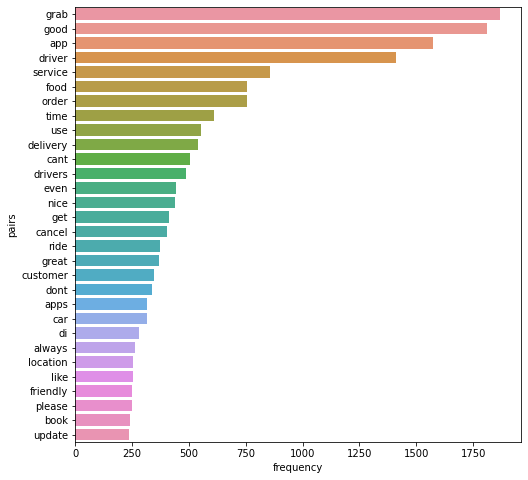

In [ ]:
df['Review_Check']  = [word_tokenize(row) for row in df['Review']]

new_tokens = []
for i in df['Review_Check'].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

#### Detecting the languages present in our corpus.

In [ ]:
def detect_language(text):
    if len(text) > 4: #only attempt detection if text is longer than 4 characters to avoid noise
        try:
            lang_code = detect(text)
            lang_name = pycountry.languages.get(alpha_2=lang_code).name
        except (LangDetectException, KeyError):
            lang_name = 'unknown'
        return lang_name
    else:
        return 'unknown'

#Process done.
#languages_counts = df['Review'].apply(detect_language).value_counts()

#for lang, count in languages_counts.head(10).items():
    #print(f"{lang}: {count}")

English: 4396
unknown: 1392
Indonesian: 1041
Tagalog: 434
Danish: 346
French: 319
Romanian: 230
Afrikaans: 228
Croatian: 217
Italian: 200


#### Langdetect shows that we have a vast majority of english reviews 

However, it is accompanied by 1000 reviews of an unknown language (might be typos and noisy data) and another 1000 reviews in indonesian malay.
We will clean the data further and include Indonesian Malay words in our preprocessing.

#### Removing stop words as a preprocessing step is not advised for BERTopic as the transformer-based embedding models that we use need the full context in order to create accurate embeddings.

#### Now to perform lemmatization

In [ ]:
df['Review']  = [word_tokenize(row) for row in df['Review']]

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['Review'] = df['Review'].apply(lemmatize_text)
df["Review"]=df["Review"].apply(lambda x:" ".join(x))

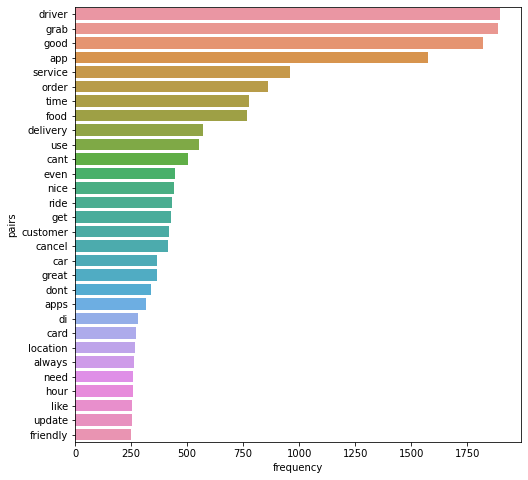

In [ ]:
df['Review_Check']  = [word_tokenize(row) for row in df['Review']]

new_tokens = []
for i in df['Review_Check'].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

#### Fitting our model

In [ ]:
#Insteal, we use the CountVectorizer to preprocess our documents after having generated embeddings and clustered our documents
stop_words_concat = stopwords.words('english') + stopwords.words('indonesian')
vectorizer_model = CountVectorizer(stop_words=stop_words_concat) 

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) #to reduce the impact of frequent words
representation_model = KeyBERTInspired() #KeyBERT-Inspired model to  identify and extract the most important keywords and phrases from the text data
umap_model = UMAP(n_neighbors=15, min_dist=0.0, metric='cosine')
#UMAP to perform its dimensionality reduction.

#HDBSCAN: This can be resolved by reducing the number of topics automatically. 
#To do this, we can use HDBSCAN to cluster our topics using each c-TF-IDF representation. 
#Then, we merge topics that are clustered together. 
#Another benefit of HDBSCAN is that it generates outliers. 
#These outliers prevent topics from being merged if no other topics are similar.

text = df["Review"].to_list()

topic_model = BERTopic(
    language="multilingual", 
    n_gram_range=(1, 1), 
    verbose=True, 
    calculate_probabilities=True,
    nr_topics='auto', #number of topics auto generated by HDBSCAN
    min_topic_size=15, #minimum topic size set to 15
    vectorizer_model=vectorizer_model, 
    ctfidf_model=ctfidf_model, 
    representation_model=representation_model, 
    umap_model=umap_model)

topics, probs = topic_model.fit_transform(text)

# Preprocess Documents
documents = pd.DataFrame({"Document": text,
                          "ID": range(len(text)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()


2023-03-29 21:41:48,839 - BERTopic - Transformed documents to Embeddings


2023-03-29 21:41:58,585 - BERTopic - Reduced dimensionality
2023-03-29 21:42:04,585 - BERTopic - Clustered reduced embeddings
2023-03-29 21:42:26,968 - BERTopic - Reduced number of topics from 129 to 32


In [ ]:
# get the topic frequencies
topic_freq = topic_model.get_topic_freq()

# print the number of topics
num_topics = len(topic_freq)
print(f"Number of topics: {num_topics}")

Number of topics: 32


In [ ]:
print(f"Coherence Score: {coherence}")

#### Generating an Intertopic Distance Map to get a 2D representation of our topics.

In [ ]:
topic_model.visualize_topics()

#### Visualizing Topic Hierarchy
Lines between each topic/node show the distance between the topics in the model. The height represents the distance between the topics.

The shorter the line, the more closely related the two topics are.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

#### Visualizing the Terms

By looking at the relative c-TF-IDF scores between and within each topic, we can easily compare each topic to one another.

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

#### Let's try reducing our number of topics to a smaller number

In [ ]:
topic_model.reduce_topics(text, nr_topics=20)

2023-03-29 21:43:04,730 - BERTopic - Reduced number of topics from 32 to 20


#### Re-visualizing our updated model

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

#### Let's give the topic labels automatically generated by BERTopic.

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=1,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")

topic_model.set_topic_labels(topic_labels)

In [ ]:
topic_model.visualize_barchart(top_n_topics=20, custom_labels=True)

#### Some topic labels are not the best. So we will manually update it. Based on the barchart above

In [ ]:
print(topic_labels)

['customer', 'taxi', 'grabfood', 'cashless', 'map', 'apps', 'account', 'reliable', 'timeurgent', 'malaysia', 'grabcar', 'chatbox', 'sip', 'promonya', 'foodpanda', 'courteous', 'bad', 'useless', 'face', 'app']


In [ ]:
topic_labels_dict = {}
start = -1

for x in topic_model.get_topic_info()["CustomName"]:
    topic_labels_dict[start] = x
    start+=1

topic_labels_dict[-1] = "outlier"
topic_labels_dict[0] = "grabcar"
topic_labels_dict[2] = "payment"
topic_labels_dict[3] = "location"
topic_labels_dict[6] = "reliability"
topic_labels_dict[7] = "speed"
topic_labels_dict[8] = "country"
topic_labels_dict[9] = "grab_services"
topic_labels_dict[10] = "helpdesk"
topic_labels_dict[11] = "car_condition"
topic_labels_dict[12] = "promotion"
topic_labels_dict[14] = "politeness"
topic_labels_dict[17] = "face_recognition"
topic_labels_dict[18] = "app_crash"

print(topic_labels_dict)

{-1: 'outlier', 0: 'grabcar', 1: 'grabfood', 2: 'payment', 3: 'location', 4: 'apps', 5: 'account', 6: 'reliability', 7: 'speed', 8: 'country', 9: 'grab_services', 10: 'helpdesk', 11: 'car_condition', 12: 'promotion', 13: 'foodpanda', 14: 'politeness', 15: 'bad', 16: 'useless', 17: 'face_recognition', 18: 'app_crash'}


In [ ]:
map_function = lambda x: topic_labels_dict[x]

# Get the topic predictions
topic_prediction = topic_model.topics_[:]
# Save the predictions in the dataframe
df['topic_prediction'] = topic_prediction

df["Topic Labels"] = df["topic_prediction"].apply(map_function)

# Take a look at the data
df.sample(10)

,Full Text Review,Review,Score,Date,topic_prediction,Topic Labels
1621,really good,really good,5,2023-01-21 18:46:16,0,grabcar
6250,friendly helpful respectful,friendly helpful respectful,5,2022-11-26 22:38:34,14,politeness
1514,md,md,5,2023-01-23 02:07:56,0,grabcar
7253,conducted professionally showed lots patience ...,conducted professionally showed lot patience r...,5,2022-11-14 19:32:36,-1,outlier
1703,good apps,good apps,5,2023-01-20 17:54:26,0,grabcar
1010,policies grab seems protecting drivers riders ...,policy grab seems protecting driver rider ride...,1,2023-01-29 16:57:21,0,grabcar
8213,legend app,legend app,5,2022-11-03 07:05:49,0,grabcar
3813,convenience way overpriced,convenience way overpriced,3,2022-12-23 17:40:43,2,payment
7152,help centre disfunctional stuck cant go home d...,help centre disfunctional stuck cant go home d...,1,2022-11-15 23:32:48,0,grabcar
7759,scan qr code galary please help,scan qr code galary please help,5,2022-11-08 15:46:18,1,grabfood


In [ ]:
df_original = pd.read_csv("cleaned_grab_playstore_reviews.csv")
df.insert(0,'Full Text Review', df_original["Review"])

#### We include bigrams into our model to try and evaluate our model's performance

In [ ]:
topic_model.update_topics(text, n_gram_range=(1, 2))

In [ ]:
topic_model.visualize_barchart(top_n_topics=20, custom_labels=True)

#### Bigrams did not improve our model by much, so we will stick to unigrams. 

#### Finally, we import our dataframe into a csv.

In [ ]:
df_output = df.copy()
df_output.drop('Review', axis=1, inplace=True)
df_output.drop('topic_prediction', axis=1, inplace=True)
df_output.sample(10)

In [ ]:
df_output.to_csv('topic_modelling_labelled_corpus_BERTopic.csv', index=False)